In [19]:
!pip install tqdm

In [19]:
import numpy as np
from tqdm import tqdm
import gym as gym
import matplotlib.pyplot as plt

class CrossEntropyAgent:
    def __init__(self, state_n, action_n, stochastic_env=False, smoothing=None, alpha=0.01, beta=0.1):
        self.state_n = state_n
        self.action_n = action_n
        self.stochastic_env = stochastic_env
        self.smoothing = smoothing
        self.alpha = alpha  # Laplace smoothing constant
        self.beta = beta    # Policy smoothing factor
        self.model = np.ones((state_n, action_n)) / action_n

    def get_action(self, state):
        probs = self.model[state]
        action = np.random.choice(self.action_n, p=probs)
        return action

    def fit(self, elite_trajectories):
        new_model = np.zeros_like(self.model)
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                new_model[state, action] += 1

        for state in range(self.state_n):
            if self.smoothing == "laplace":
                new_model[state] = ((new_model[state] + self.alpha) / (np.sum(new_model[state]) + self.action_n * self.alpha))
            elif self.smoothing == "policy":
                new_model[state] = (new_model[state] * self.beta + (1 - self.beta) * self.model[state])
                new_model[state] /= np.sum(new_model[state])
            else:
                if np.sum(new_model[state]) > 0:
                    new_model[state] /= np.sum(new_model[state])
                else:
                    new_model[state] = self.model[state].copy()

        self.model = new_model

    def generate_trajectories(self, env, trajectory_n, m):
        total_rewards = []
        if self.stochastic_env:
            stochastic_policy = self.model.copy()
            trajectories = []

            for iteration in tqdm(range(m), desc="Iteration"):
                determ_policy = np.zeros((self.state_n, self.action_n))
                for state in range(self.state_n):
                    action = np.random.choice(np.arange(self.action_n), p=stochastic_policy[state])
                    determ_policy[state][action] = 1

                self.model = determ_policy
                trs = [self.get_trajectory(env) for _ in range(trajectory_n)]
                trajectories += trs
                local_reward = np.mean([np.sum(traj['rewards']) for traj in trs])
                total_rewards.extend([local_reward for _ in trs])

            self.model = stochastic_policy
        return trajectories, total_rewards

    def get_trajectory(self, env, max_len=1000):
        trajectory = {'states': [], 'actions': [], 'rewards': []}
        state = env.reset()
        for _ in range(max_len):
            action = self.get_action(state)
            next_state, reward, done, _ = env.step(action)
            trajectory['states'].append(state)
            trajectory['actions'].append(action)
            trajectory['rewards'].append(reward)
            state = next_state
            if done:
                break
        return trajectory


def train_agent(agent, env, iteration_n, trajectory_n, m, q_param_values):
    results = {q_param: [] for q_param in q_param_values}

    for q_param in q_param_values:
        mean_total_rewards = []

        for iteration in range(iteration_n):
            if agent.stochastic_env:
                trajectories, total_rewards = agent.generate_trajectories(env, trajectory_n, m)
            else:
                trajectories = [agent.get_trajectory(env) for _ in range(trajectory_n)]
                total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]

            quantile = np.quantile(total_rewards, q_param)
            elite_trajectories = [trajectory for trajectory in trajectories if np.sum(trajectory['rewards']) >= quantile]

            agent.fit(elite_trajectories)
            mean_total_rewards.append(np.mean(total_rewards))

        results[q_param] = mean_total_rewards

    return results

Testing configuration: {'stochastic_env': True, 'smoothing': 'laplace', 'alpha': 0.01, 'beta': 0.1}


Iteration: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Testing configuration: {'stochastic_env': True, 'smoothing': 'policy', 'alpha': 0.05, 'beta': 0.2}


Iteration: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Testing configuration: {'stochastic_env': True, 'smoothing': None, 'alpha': 0.01, 'beta': 0.1}


Iteration: 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Configuration: {'stochastic_env': True, 'smoothing': 'laplace', 'alpha': 0.01, 'beta': 0.1}
Results: {0.8: [-1159.985, -202.7, -200.0, -200.0, -200.45, -200.0, -200.45, -200.9, -200.45, -200.45, -200.0, -201.35, -200.0, -201.35, -200.45, -200.0, -200.0, -200.45, -200.0, -200.9]}

Configuration: {'stochastic_env': True, 'smoothing': 'policy', 'alpha': 0.05, 'beta': 0.2}
Results: {0.8: [-1204.65875, -221.1455, -201.35, -200.45, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0]}

Configuration: {'stochastic_env': True, 'smoothing': None, 'alpha': 0.01, 'beta': 0.1}
Results: {0.8: [-1185.82175, -206.75, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0]}



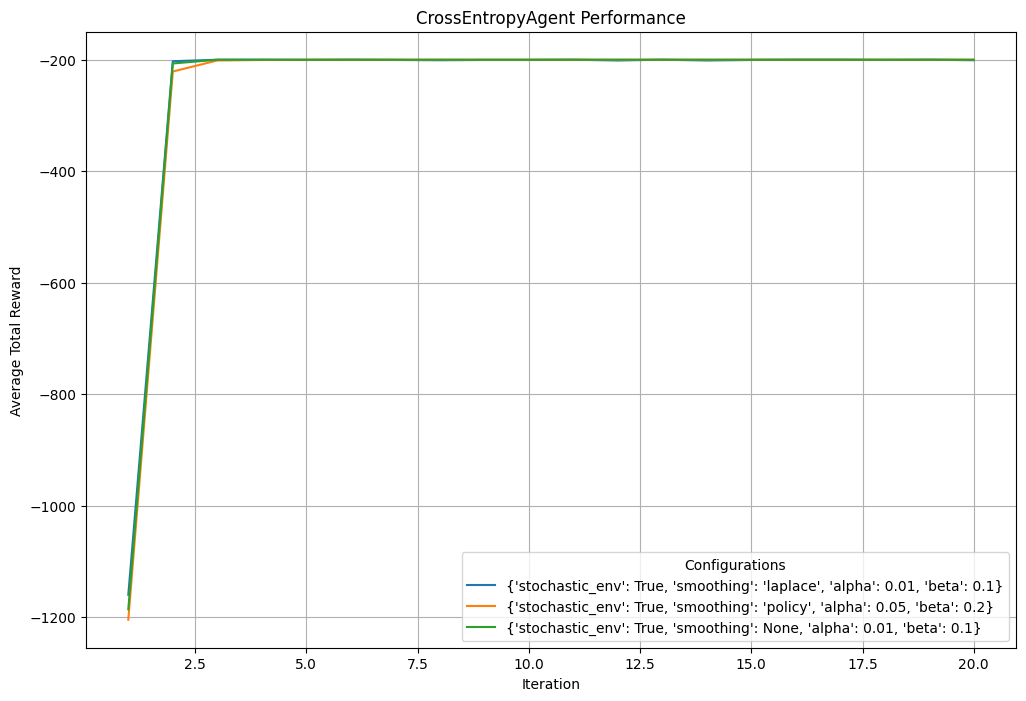

In [26]:
def test_agent(env_name, state_n, action_n, iteration_n, trajectory_n, m, q_param_values, test_configs):
    env = gym.make(env_name)
    results = {}

    for config in test_configs:
        agent = CrossEntropyAgent(state_n=state_n,
                                  action_n=action_n,
                                  stochastic_env=config['stochastic_env'],
                                  smoothing=config['smoothing'],
                                  alpha=config['alpha'],
                                  beta=config['beta'])

        print(f"Testing configuration: {config}")
        config_results = train_agent(agent, env, iteration_n, trajectory_n, m, q_param_values)
        results[str(config)] = config_results

    return results

test_configs = [
    {'stochastic_env': True, 'smoothing': 'laplace', 'alpha': 0.01, 'beta': 0.1},
    {'stochastic_env': True, 'smoothing': 'policy', 'alpha': 0.05, 'beta': 0.2},
    {'stochastic_env': True , 'smoothing': None, 'alpha': 0.01, 'beta': 0.1}
]

env = gym.make('Taxi-v3')
state_n = env.observation_space.n
action_n = env.action_space.n
agent = CrossEntropyAgent(state_n, action_n)

iteration_n = 20
trajectory_n = 200
m = 20
q_param_values = [0.8]

results = test_agent('Taxi-v3', state_n, action_n, iteration_n, trajectory_n, m, q_param_values, test_configs)

for config, result in results.items():
    print(f"Configuration: {config}")
    print(f"Results: {result}\n")

def plot_results(results):
    plt.figure(figsize=(12, 8))

    for config, rewards in results.items():
        iterations = range(1, len(rewards[q_param_values[0]]) + 1)
        plt.plot(iterations, rewards[q_param_values[0]], label=config)

    plt.title("CrossEntropyAgent Performance")
    plt.xlabel("Iteration")
    plt.ylabel("Average Total Reward")
    plt.legend(title="Configurations")
    plt.grid(True)
    plt.show()

plot_results(results)